In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
ind_time_filepath = "output_data_au/Simulation_Results_2023-08-15T100831.821222/individual_time_point_data.csv"
raw_data = "PROM-RulesBasedAlgorithmData_R2.0.xlsx"
# ind_time_filepath = "output_data_pilot/Simulation_Results_2023-08-03T134722.370088/individual_time_point_data.csv"

In [3]:
domain_code_to_name = {"ui_domain" : "Urinary Incontinence Domain",
                      "sf_domain" : "Sexual Function Domain",
                       "uio_domain" : "Urinary Obstruction Domain",
                       "bf_domain" : "Bowel Function Domain",
                       "hf_domain" : "Hormonal Function Domain",
                       "q6d" : "Blood Stools Question"
                      }

In [4]:
unfiltered_ind_time_df = pd.read_csv(ind_time_filepath)
unfiltered_raw_data_df = pd.read_excel(raw_data, sheet_name="PROM-RulesBasedAlgorithmData_R2")
print(len(unfiltered_ind_time_df))
print(unfiltered_ind_time_df.head())
print(len(unfiltered_raw_data_df))
print(unfiltered_raw_data_df.head())

16319
  Patient Identifier           Time Point Urinary Incontinence Domain State  \
0  15970_370765.json  2019-04-09 00:00:00                            Normal   
1  15970_413565.json  2020-12-05 00:00:00                          Abnormal   
2   9204_198609.json  2015-05-12 00:00:00                            Normal   
3   9204_235725.json  2015-11-04 00:00:00                            Normal   
4   9204_279366.json  2016-08-29 22:25:00                            Normal   

  Urinary Irritation/Obstruction Domain State Bowel Function Domain State  \
0                     Clinically Urgent Alert                      Normal   
1                     Clinically Urgent Alert                      Normal   
2                                      Normal                      Normal   
3                                      Normal                    Abnormal   
4                     Clinically Urgent Alert                      Normal   

  Q6d State Sexual Function Domain State Hormonal Functi

# Preprocessing

In [5]:
# Remove participants with missing age data
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['AgeAtDx'].isin(list(range(0, 100))))]

# Format as [(participant_id, report_id)]
participant_df = list(participant_df['CapstudiesID'])
report_id_data = unfiltered_raw_data_df.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
keep_ids = [(participant_id, report_id) for participant_id, lo_report_id in report_id_data.items() for report_id in lo_report_id if participant_id in participant_df]

# Filter raw data
filtered_raw_data_df1 = unfiltered_raw_data_df[(unfiltered_raw_data_df[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df1 = unfiltered_ind_time_df[(unfiltered_ind_time_df['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count0 = len(set(unfiltered_raw_data_df['CapstudiesID']))
participant_count1 = len(set(filtered_raw_data_df1['CapstudiesID']))
print(f"{participant_count0} -> {participant_count1} participants")
print(f"{len(unfiltered_raw_data_df)} -> {len(filtered_raw_data_df1)} alerts")

5147 -> 4935 participants
16319 -> 15717 alerts


In [6]:
# Remove participants with null values for questionnaire responses
m=filtered_ind_time_df1.isnull().sum(axis=1)
m=m[~m.isin([0])].index.unique()

report_id_data = unfiltered_raw_data_df.loc[m].groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
keep_ids = [(participant_id, report_id) for participant_id, lo_report_id in report_id_data.items() for report_id in lo_report_id]

# Filter raw data
filtered_raw_data_df2 = filtered_raw_data_df1[(filtered_raw_data_df1[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df2 = filtered_ind_time_df1[(filtered_ind_time_df1['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count2 = len(set(filtered_raw_data_df2['CapstudiesID']))
print(f"{participant_count1} -> {participant_count2} participants")
print(f"{len(filtered_ind_time_df1)} -> {len(filtered_ind_time_df2)} alerts")

4935 -> 4933 participants
15717 -> 15127 alerts


## Keep first 4 reports for participants with >=4 reports

In [7]:
# keep participants with at least 4 reports
report_id_data = filtered_raw_data_df2.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
interval_data = filtered_raw_data_df2.groupby('CapstudiesID')['Interval'].apply(list).to_dict()
keep_ids = [] # [(patient_id, report_id)]
participant_count3 = 0
for id in report_id_data.keys():
    if len(interval_data[id]) >= 4 and len(interval_data[id]) == len(list(set(interval_data[id]))):
        participant_count3 += 1
        to_keep = list(zip(report_id_data[id], interval_data[id]))
        to_keep = sorted(to_keep, key=lambda x: x[1]) # sort by interval
        keep_ids += [(id, x[0]) for x in to_keep[:4]] # keep first 4 reports

# Filter raw data
filtered_raw_data_df3 = filtered_raw_data_df2[(filtered_raw_data_df2[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df3 = filtered_ind_time_df2[(filtered_ind_time_df2['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

print(f"{participant_count2} -> {participant_count3} participants")
print(f"{len(filtered_ind_time_df2)} -> {len(filtered_ind_time_df3)} alerts")
date_points = ["0", "3", "6-12", "24-60"] # measured in months

4933 -> 1412 participants
15127 -> 5648 alerts


## Sort by initial alert type

In [8]:
report_id_data = filtered_raw_data_df3.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
interval_data = filtered_raw_data_df3.groupby('CapstudiesID')['Interval'].apply(list).to_dict()
alert_data = filtered_ind_time_df3.groupby('Patient Identifier')['Final Alert State'].apply(list).to_dict()

normal_ids = [] # [(patient_id, report_id)]
urgent_ids = [] # [(patient_id, report_id)]
for id in report_id_data.keys():
    to_keep = list(zip(report_id_data[id], interval_data[id], [alert_data[f"{id}_{report_id}.json"][0] for report_id in report_id_data[id]]))
    to_keep = sorted(to_keep, key=lambda x: x[1]) # sort by interval
    if to_keep[0][2] == 'Normal':
        normal_ids += [(id, x[0]) for x in to_keep]
    elif to_keep[0][2] == 'Clinically Urgent Alert':
        urgent_ids += [(id, x[0]) for x in to_keep]

print("Starting normal:")
keep_ids = normal_ids

normal_participant_count = len(set([id[0] for id in keep_ids]))

# Filter raw data
normal_filtered_raw_data_df = filtered_raw_data_df3[(filtered_raw_data_df3[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
normal_filtered_ind_time_df = filtered_ind_time_df3[(filtered_ind_time_df3['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

print(f"{participant_count3} -> {normal_participant_count} participants")
print(f"{len(filtered_ind_time_df3)} -> {len(normal_filtered_ind_time_df)} alerts")

print("Starting urgent:")
keep_ids = urgent_ids
urgent_participant_count = len(set([id[0] for id in keep_ids]))

# Filter raw data
urgent_filtered_raw_data_df = filtered_raw_data_df3[(filtered_raw_data_df3[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
urgent_filtered_ind_time_df = filtered_ind_time_df3[(filtered_ind_time_df3['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

print(f"{participant_count3} -> {urgent_participant_count} participants")
print(f"{len(filtered_ind_time_df3)} -> {len(urgent_filtered_raw_data_df)} alerts")

Starting normal:
1412 -> 640 participants
5648 -> 2560 alerts
Starting urgent:
1412 -> 753 participants
5648 -> 3012 alerts


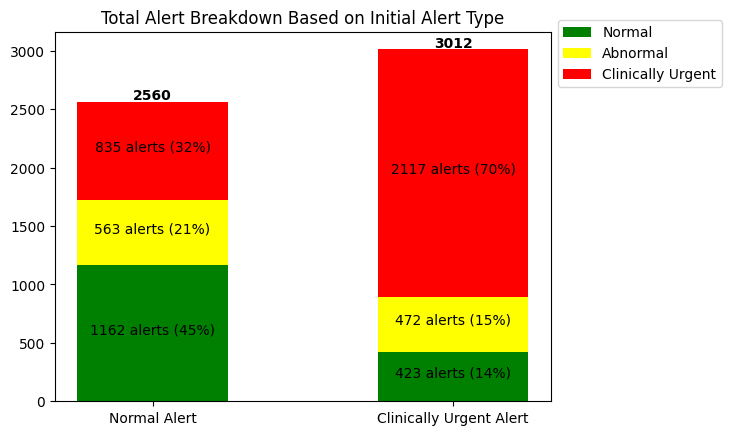

In [9]:
# Look at the frequency for the different types of alerts (normal, abnormal, clinically urgent)
alert_counts_normal = normal_filtered_ind_time_df['Final Alert State'].value_counts()
alert_counts_urgent = urgent_filtered_ind_time_df['Final Alert State'].value_counts()

start_alert = (
    "Normal Alert",
    "Clinically Urgent Alert",
)
alert_counts = {
    "Normal": np.array([alert_counts_normal['Normal'], alert_counts_urgent['Normal']]),
    "Abnormal": np.array([alert_counts_normal['Abnormal'], alert_counts_urgent['Abnormal']]),
    "Clinically Urgent": np.array([alert_counts_normal['Clinically Urgent Alert'], alert_counts_urgent['Clinically Urgent Alert']]),
}

total_alert_counts = [len(normal_filtered_raw_data_df), len(urgent_filtered_raw_data_df)]

alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(start_alert, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_alert_counts[i%2])}%)", ha = 'center',
      color = 'black', size = 10)

# Total Labels
for i in range(len(total_alert_counts)): 
    ax.text(i, total_alert_counts[i] + 20, round(total_alert_counts[i]), ha = 'center', weight = 'bold', color = 'black')
    
ax.set_title("Total Alert Breakdown Based on Initial Alert Type")
ax.legend(bbox_to_anchor=(1, 1.05))


plt.show()

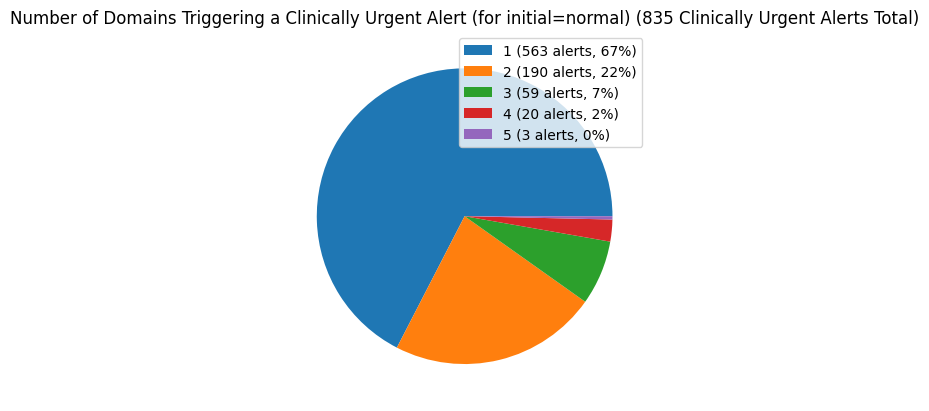

In [18]:
# Number of domains triggering a clinically urgent alert
no_triggering_domains = normal_filtered_ind_time_df.groupby('Final Alert State')['Alerting Domains'].apply(list)
no_triggering_domains = [len(triggering_domains.strip('[]').replace("'", "").split(', ')) for triggering_domains in no_triggering_domains["Clinically Urgent Alert"]]
no_triggering_domains = [(triggering_domains, no_triggering_domains.count(triggering_domains)) for triggering_domains in set(no_triggering_domains)]
total_alerts = sum([int(no[1]) for no in no_triggering_domains])

plt.pie([no[1] for no in no_triggering_domains])
plt.legend([f"{no[0]} ({no[1]} alerts, {int(100*no[1]/total_alerts)}%)" for no in no_triggering_domains])
plt.title(f"Number of Domains Triggering a Clinically Urgent Alert (for initial=normal) ({total_alerts} Clinically Urgent Alerts Total)")
plt.show()

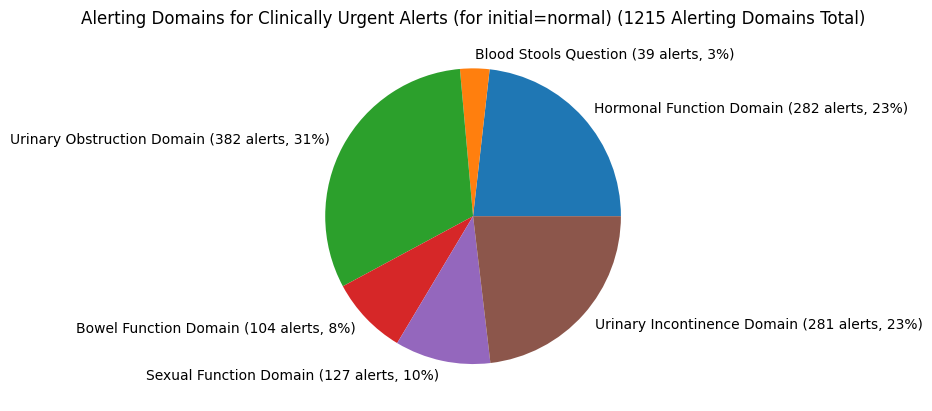

In [19]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(normal_filtered_ind_time_df[normal_filtered_ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts (for initial=normal) ({total_alerts} Alerting Domains Total)")
plt.show()

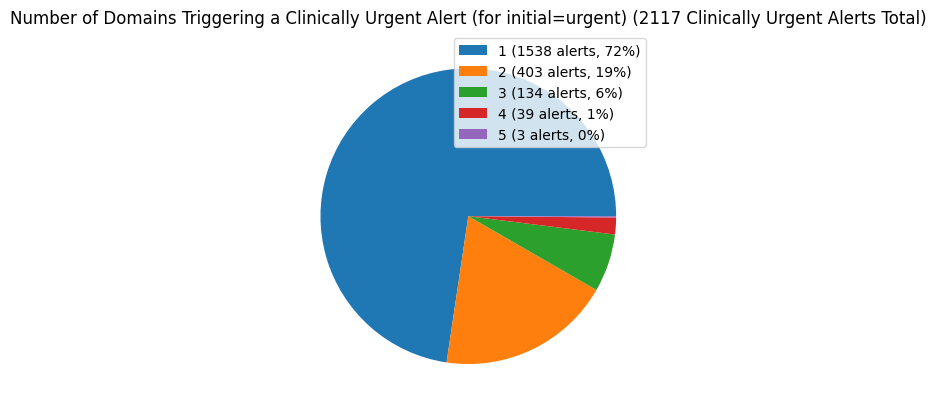

In [22]:
# Number of domains triggering a clinically urgent alert
no_triggering_domains = urgent_filtered_ind_time_df.groupby('Final Alert State')['Alerting Domains'].apply(list)
no_triggering_domains = [len(triggering_domains.strip('[]').replace("'", "").split(', ')) for triggering_domains in no_triggering_domains["Clinically Urgent Alert"]]
no_triggering_domains = [(triggering_domains, no_triggering_domains.count(triggering_domains)) for triggering_domains in set(no_triggering_domains)]
total_alerts = sum([int(no[1]) for no in no_triggering_domains])

plt.pie([no[1] for no in no_triggering_domains])
plt.legend([f"{no[0]} ({no[1]} alerts, {int(100*no[1]/total_alerts)}%)" for no in no_triggering_domains])
plt.title(f"Number of Domains Triggering a Clinically Urgent Alert (for initial=urgent) ({total_alerts} Clinically Urgent Alerts Total)")
plt.show()

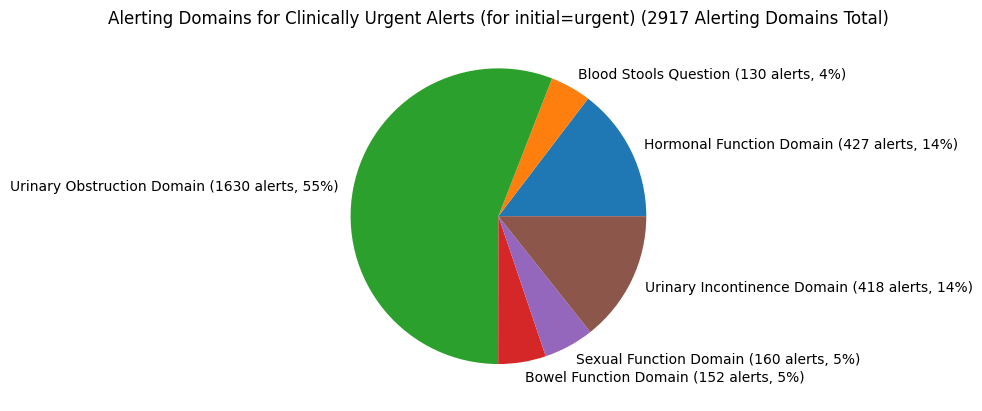

In [21]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(urgent_filtered_ind_time_df[urgent_filtered_ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts (for initial=urgent) ({total_alerts} Alerting Domains Total)")
plt.show()

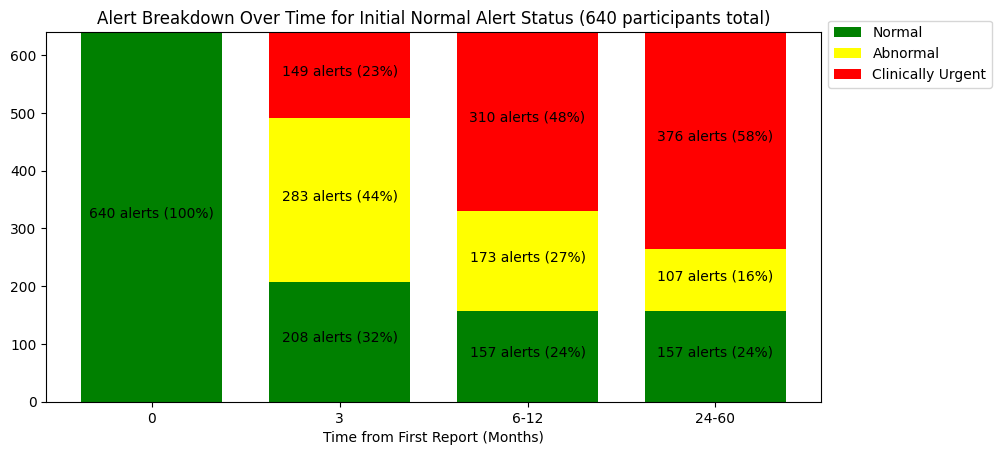

In [10]:
# Alerts by report number
alert_types = list(normal_filtered_ind_time_df['Final Alert State'])
alert_times = list(normal_filtered_ind_time_df['Time Point'])
patient_ids = list(normal_filtered_ind_time_df['Patient Identifier'])
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

old_counts = alert_counts
alert_counts = { 
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}

total_alert_counts = [sum(old_counts[date].values()) for date in date_points]

alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/normal_participant_count)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Initial Normal Alert Status ({normal_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


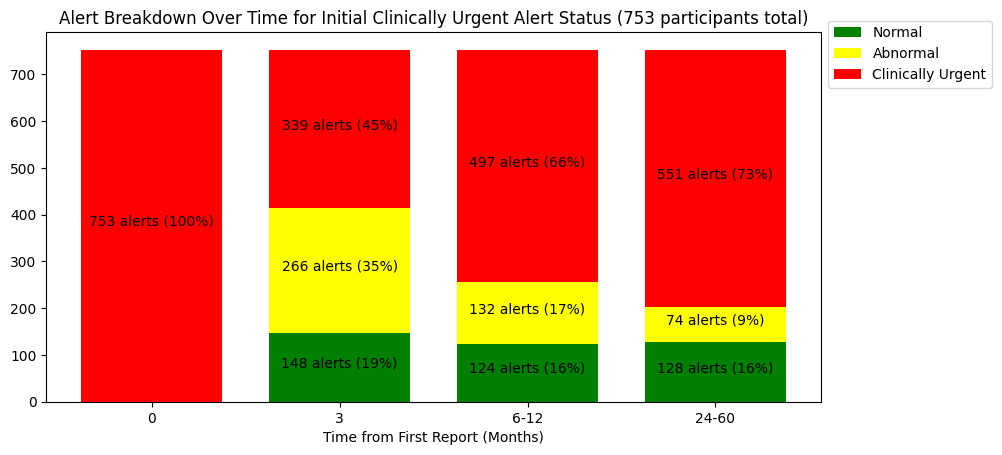

In [12]:
# Alerts by report number
alert_types = list(urgent_filtered_ind_time_df['Final Alert State'])
alert_times = list(urgent_filtered_ind_time_df['Time Point'])
patient_ids = list(urgent_filtered_ind_time_df['Patient Identifier'])
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

alert_counts[date_points[0]] = {"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": urgent_participant_count}
old_counts = alert_counts
alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}

total_alert_counts = [sum(old_counts[date].values()) for date in date_points]

alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/urgent_participant_count)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Initial Clinically Urgent Alert Status ({urgent_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


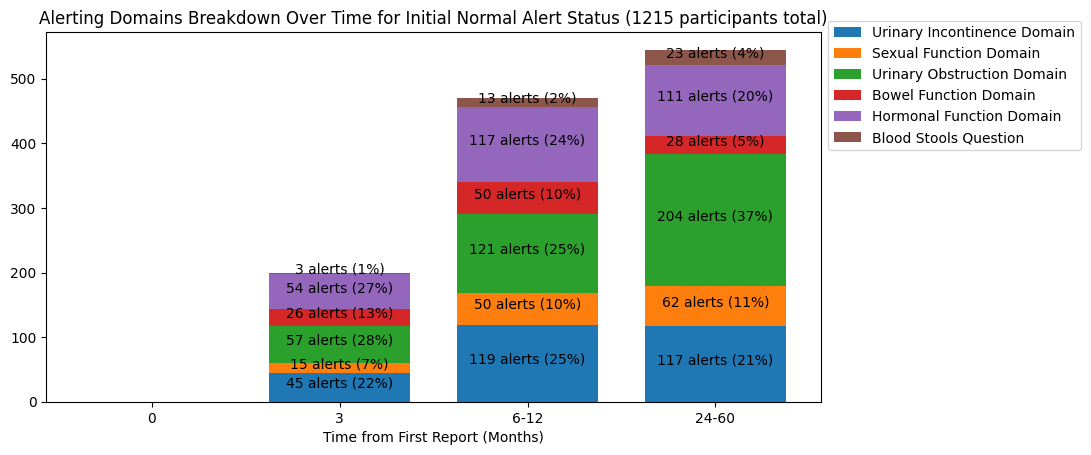

In [58]:
# Alerts by report number
alert_types = list(normal_filtered_ind_time_df['Final Alert State'])
alert_times = list(normal_filtered_ind_time_df['Time Point'])
patient_ids = list(normal_filtered_ind_time_df['Patient Identifier'])
alerting_domains = list(normal_filtered_ind_time_df['Alerting Domains'])
alerts_by_patient = {} # {id : [(datetime, alert_type, alerting_domains)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i], alerting_domains[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i], alerting_domains[i]))

alert_counts = zip(date_points, [{"ui_domain": 0, "sf_domain": 0, "uio_domain": 0, "bf_domain": 0, "hf_domain":0, "q6d":0} for date in date_points])
alert_counts = dict(alert_counts)
domain_list = ["ui_domain", "sf_domain", "uio_domain", "bf_domain", "hf_domain", "q6d"]
for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][2]) for i in range(len(alerts_by_patient[patient_id])) if alerts_by_patient[patient_id][i][1] == "Clinically Urgent Alert"]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        for domain in domain_list:
            if domain in sorted_alerts[i][1]:
                alert_counts[date_points[i]][domain] += 1

old_counts = alert_counts
alert_counts = { 
    domain_code_to_name["ui_domain"]: np.flip(np.array([old_counts[date]["ui_domain"] for date in date_points]), 0),
    domain_code_to_name["sf_domain"]: np.flip(np.array([old_counts[date]["sf_domain"] for date in date_points]), 0),
    domain_code_to_name["uio_domain"]: np.flip(np.array([old_counts[date]["uio_domain"] for date in date_points]), 0),
    domain_code_to_name["bf_domain"]: np.flip(np.array([old_counts[date]["bf_domain"] for date in date_points]), 0),
    domain_code_to_name["hf_domain"]: np.flip(np.array([old_counts[date]["hf_domain"] for date in date_points]), 0),
    domain_code_to_name["q6d"]: np.flip(np.array([old_counts[date]["q6d"] for date in date_points]), 0),
}

total_alert_counts = sum([sum(old_counts[date].values()) for date in date_points])
total_domain_counts = [sum(old_counts[date].values()) for date in date_points][::-1]

width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom)
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_domain_counts[i%len(total_domain_counts)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alerting Domains Breakdown Over Time for Initial Normal Alert Status ({total_alert_counts} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()

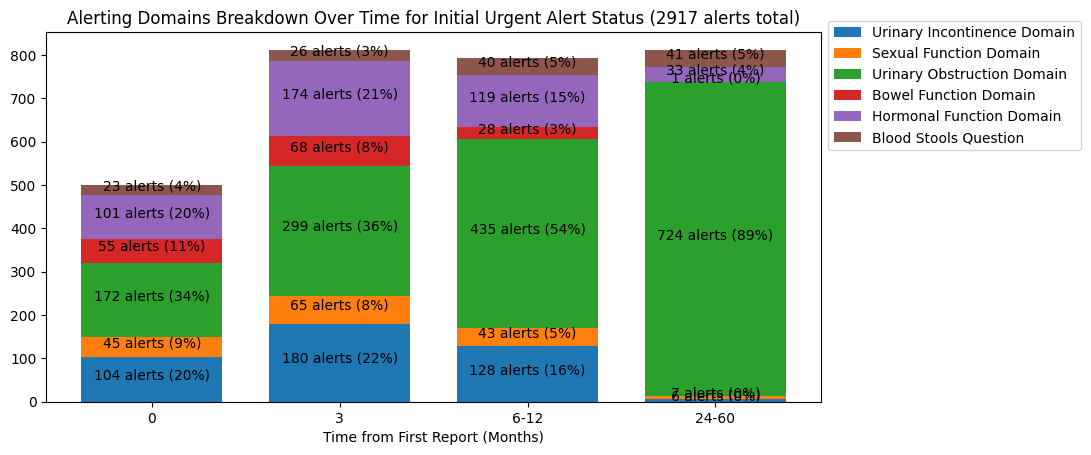

In [57]:
# Alerts by report number
alert_types = list(urgent_filtered_ind_time_df['Final Alert State'])
alert_times = list(urgent_filtered_ind_time_df['Time Point'])
patient_ids = list(urgent_filtered_ind_time_df['Patient Identifier'])
alerting_domains = list(urgent_filtered_ind_time_df['Alerting Domains'])
alerts_by_patient = {} # {id : [(datetime, alert_type, alerting_domains)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i], alerting_domains[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i], alerting_domains[i]))

alert_counts = zip(date_points, [{"ui_domain": 0, "sf_domain": 0, "uio_domain": 0, "bf_domain": 0, "hf_domain":0, "q6d":0} for date in date_points])
alert_counts = dict(alert_counts)
domain_list = ["ui_domain", "sf_domain", "uio_domain", "bf_domain", "hf_domain", "q6d"]
for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][2]) for i in range(len(alerts_by_patient[patient_id])) if alerts_by_patient[patient_id][i][1] == "Clinically Urgent Alert"]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        for domain in domain_list:
            if domain in sorted_alerts[i][1]:
                alert_counts[date_points[i]][domain] += 1

old_counts = alert_counts
alert_counts = { 
    domain_code_to_name["ui_domain"]: np.flip(np.array([old_counts[date]["ui_domain"] for date in date_points]), 0),
    domain_code_to_name["sf_domain"]: np.flip(np.array([old_counts[date]["sf_domain"] for date in date_points]), 0),
    domain_code_to_name["uio_domain"]: np.flip(np.array([old_counts[date]["uio_domain"] for date in date_points]), 0),
    domain_code_to_name["bf_domain"]: np.flip(np.array([old_counts[date]["bf_domain"] for date in date_points]), 0),
    domain_code_to_name["hf_domain"]: np.flip(np.array([old_counts[date]["hf_domain"] for date in date_points]), 0),
    domain_code_to_name["q6d"]: np.flip(np.array([old_counts[date]["q6d"] for date in date_points]), 0),
}

total_alert_counts = sum([sum(old_counts[date].values()) for date in date_points])
total_domain_counts = [sum(old_counts[date].values()) for date in date_points][::-1]

width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom)
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_domain_counts[i%len(total_domain_counts)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alerting Domains Breakdown Over Time for Initial Urgent Alert Status ({total_alert_counts} alerts total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()

# Filtering for Segmentations

In [208]:
# Change below:
use_normal = False

In [209]:
participant_count4 = normal_participant_count
filtered_ind_time_df4 = normal_filtered_ind_time_df
filtered_raw_data_df4 = normal_filtered_raw_data_df
initial_status = "Normal"
if not use_normal:
    participant_count4 = urgent_participant_count
    filtered_ind_time_df4 = urgent_filtered_ind_time_df
    filtered_raw_data_df4 = urgent_filtered_raw_data_df
    initial_status = "Clinically Urgent"
    
participant_df = pd.read_excel(raw_data, sheet_name="Person")

# keep_ids = list(participant_df["CapstudiesID"]) # no filter

In [210]:
# AGE
age_groups = ["40-64", "65-69", "70+"]
keep_ids = zip(age_groups, [list(participant_df[(participant_df["AgeAtDx"] < 65)]["CapstudiesID"]),
                           list(participant_df[(participant_df["AgeAtDx"] >= 65) & (participant_df["AgeAtDx"] < 70)]["CapstudiesID"]),
                           list(participant_df[(participant_df["AgeAtDx"] >= 70)]["CapstudiesID"])])
keep_ids = dict(keep_ids)

# Filter raw data
raw_data_df = zip(age_groups, [filtered_raw_data_df4[filtered_raw_data_df4["CapstudiesID"].isin(keep_ids[a])] for a in age_groups])
raw_data_df = dict(raw_data_df)

# Filter alg output data
ind_time_df = {}
for a in age_groups:
    keep_ids[a] = [str(pid) for pid in keep_ids[a]]
    m=filtered_ind_time_df4['Patient Identifier'].str.split('_').explode()
    m=m[m.isin(keep_ids[a])].index.unique()
    ind_time_df[a]=filtered_ind_time_df4.loc[m]

participant_count5 = [len(set(list(raw_data_df[a]['CapstudiesID']))) for a in age_groups]
alert_count = [len(ind_time_df[a]) for a in age_groups]

print(f"{participant_count4} -> {sum(participant_count5)}({participant_count5}) participants")
print(f"{len(filtered_ind_time_df4)} -> {sum(alert_count)}({alert_count}) alerts")

753 -> 753([240, 254, 259]) participants
3012 -> 3012([960, 1016, 1036]) alerts


In [ ]:
# TREATMENT TYPE
therapies = ["RP", "XRT", "OBSERVATION"]
# therapies = ["RP", "XRT", "OBSERVATION", "HORMONES", "OTHER"] # use this to view counts
keep_ids = zip(therapies, [list(participant_df[(participant_df["iTreatment"] == t)]["CapstudiesID"]) for t in therapies])
keep_ids = dict(keep_ids)

# Filter raw data
raw_data_df = zip(therapies, [filtered_raw_data_df4[filtered_raw_data_df4["CapstudiesID"].isin(keep_ids[t])] for t in therapies])
raw_data_df = dict(raw_data_df)

# Filter alg output data
ind_time_df = {}
for t in therapies:
    keep_ids[t] = [str(pid) for pid in keep_ids[a]]
    m=filtered_ind_time_df4['Patient Identifier'].str.split('_').explode()
    m=m[m.isin(keep_ids[t])].index.unique()
    ind_time_df[t]=filtered_ind_time_df4.loc[m]

participant_count5 = [len(set(list(raw_data_df[t]['CapstudiesID']))) for t in therapies]
alert_count = [len(ind_time_df[t]) for t in therapies]

print(f"{participant_count4} -> {sum(participant_count5)}({participant_count5}) participants")
print(f"{len(filtered_ind_time_df4)} -> {sum(alert_count)}({alert_count}) alerts")

# Alert Types

In [215]:
t = age_groups[2]

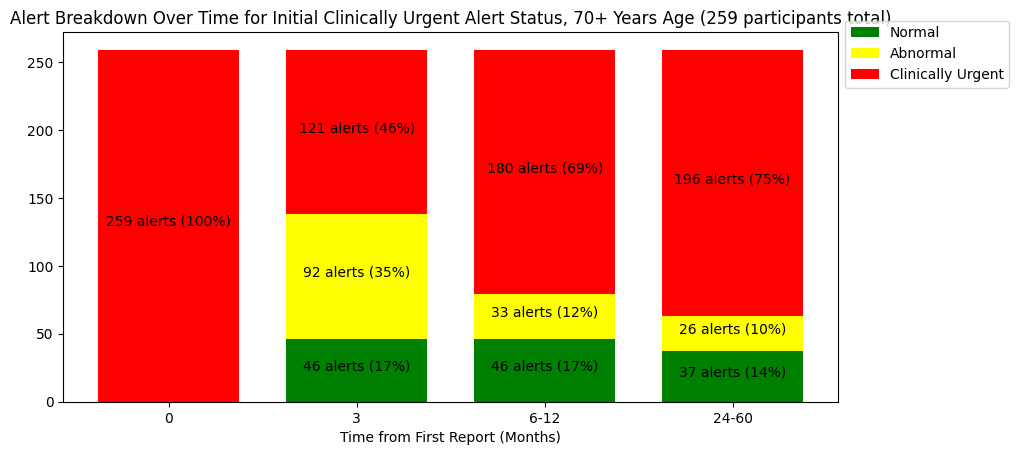

In [216]:
# Alerts by report number
alert_types = list(ind_time_df[t]['Final Alert State'])
alert_times = list(ind_time_df[t]['Time Point'])
patient_ids = list(ind_time_df[t]['Patient Identifier'])
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = datetime.strptime(alert_times[i].split(' ')[0], "%Y-%m-%d")
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        if i == 0:
            if use_normal:
                alert_counts[date_points[i]]["Normal"] += 1
            else:
                alert_counts[date_points[i]]["Clinically Urgent Alert"] += 1
            continue
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

old_counts = alert_counts
alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}
total_participant_count = len(alerts_by_patient.keys())
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(10)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_participant_count)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Initial {initial_status} Alert Status, {t} Years Age ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


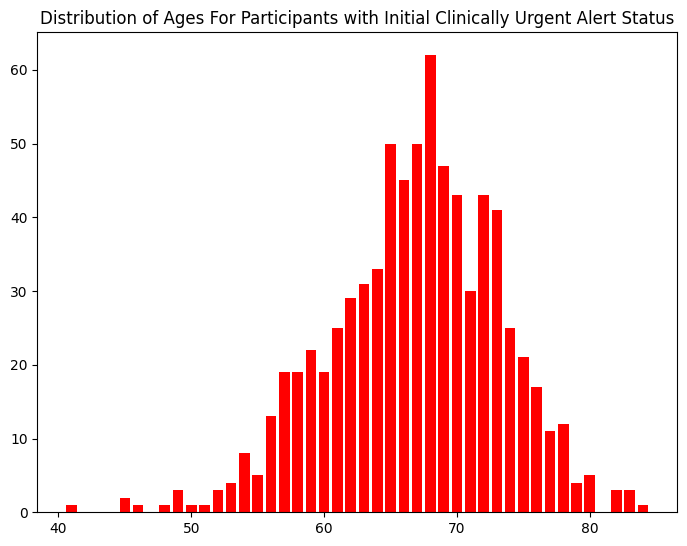

In [222]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['CapstudiesID'].isin(set([id[0] for id in urgent_ids])))]

age_counts = participant_df['AgeAtDx'].value_counts().to_dict()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ages = age_counts.keys()
counts = [age_counts[age] for age in ages]
ax.bar(ages,counts, color='r')
ax.set_title('Distribution of Ages For Participants with Initial Clinically Urgent Alert Status')
plt.show()

# Alerting Domains

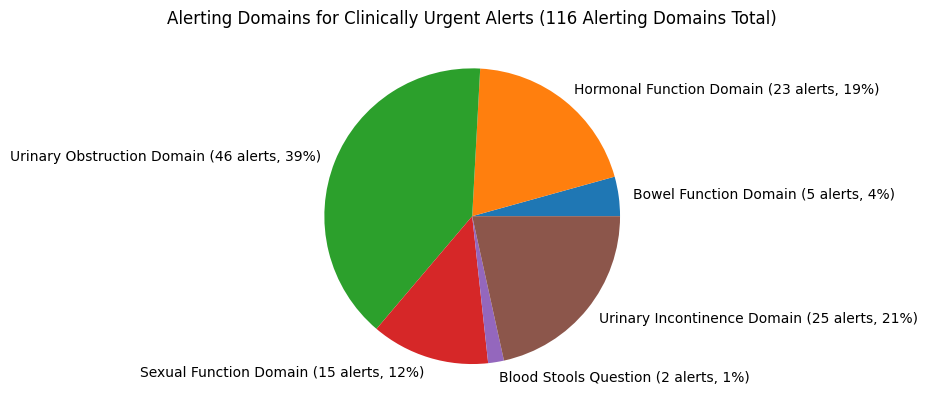

In [34]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts ({total_alerts} Alerting Domains Total)")
plt.show()

In [ ]:
# Look at the frequency of which domains trigger a clinically urgent alert

alert_domains = list(ind_time_df[ind_time_df['Final Alert State'] == 'Clinically Urgent Alert']['Alerting Domains'])
alert_domains = [sub.strip('[]').replace("'", "").split(', ') for sub in alert_domains]
alert_domains = [domain for sub in alert_domains for domain in sub]
total_alerts = len(alert_domains)
alert_domains = [[domain,alert_domains.count(domain)] for domain in set(alert_domains)]
plt.pie([sub[1] for sub in alert_domains], labels = [f"{domain_code_to_name[sub[0]]} ({sub[1]} alerts, {int(100*sub[1]/total_alerts)}%)" for sub in alert_domains])
plt.title(f"Alerting Domains for Clinically Urgent Alerts ({total_alerts} Alerting Domains Total)")
plt.show()